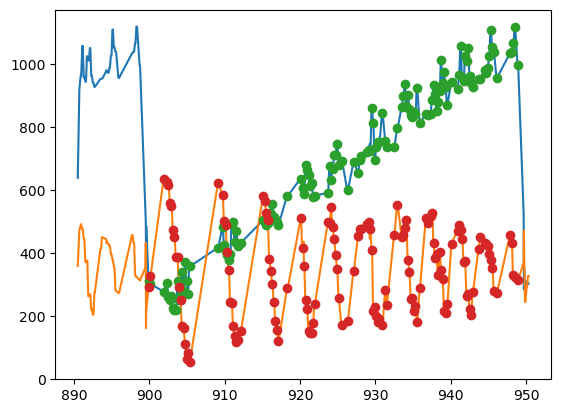

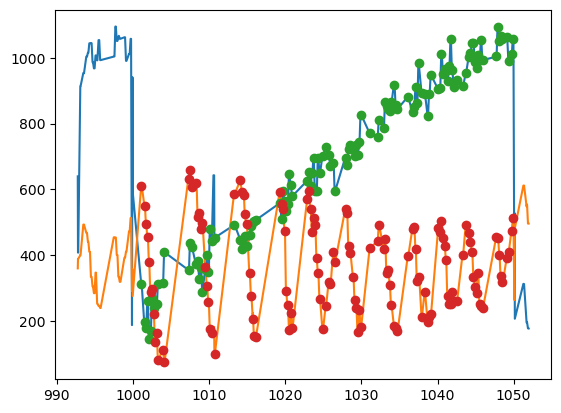

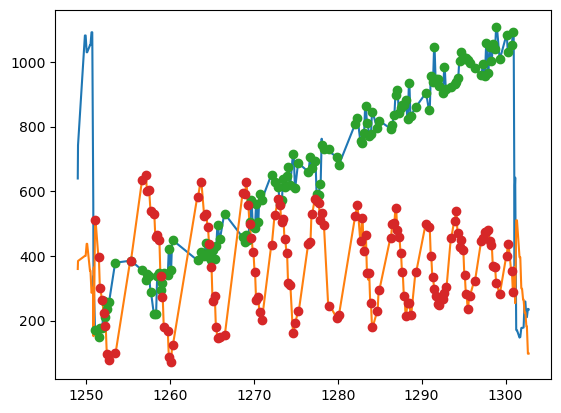

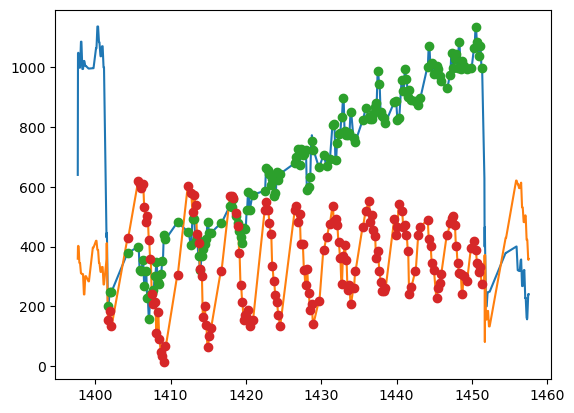

In [1]:
import numpy as np
import rosbag
import cv2
import matplotlib.pyplot as plt
from cv_bridge import CvBridge
from scipy.interpolate import interp1d

numBulbs = 50 * 5
bagFiles = [
    '/home/garamizo/bags/xmas/2022-12-09-09-11-32.bag',
    '/home/garamizo/bags/xmas/2022-12-09-09-13-14.bag',
    '/home/garamizo/bags/xmas/2022-12-09-09-17-31.bag',
    '/home/garamizo/bags/xmas/2022-12-09-09-19-59.bag']

class BulbSegmenter:

    def __init__(self):

        self.backSub = cv2.createBackgroundSubtractorMOG2()

        params = cv2.SimpleBlobDetector_Params()
        params.minThreshold = 64
        params.maxThreshold = 256
        params.minDistBetweenBlobs = 200.0
        params.filterByInertia = False
        params.filterByConvexity = False
        params.filterByColor = False
        params.filterByCircularity = False
        params.filterByArea = False
        params.minArea = 10.0
        params.maxArea = 1e10
        self.detector = cv2.SimpleBlobDetector_create(params)

    def detect(self, img):
        fgMask = self.backSub.apply(img)
        keypoints = self.detector.detect(fgMask)

        if len(keypoints) > 0:
            i = np.argmax([d.size for d in keypoints])
            return True, {'x': keypoints[i].pt[0], 'y': keypoints[i].pt[1], 
                'size': keypoints[i].size, 'num': len(keypoints)}
        else:
            return False, None

# interpolate points
def interpolate_bulbs(numBulbs, allPoints, time, numDetections):
    tStart = np.mean(time[(numDetections > 5) & (time < time[0] + 30)])
    tEnd = np.mean(time[(numDetections > 5) & (time > time[-1] - 30)])

    ttime = np.linspace(tStart, tEnd, numBulbs + 2)[1:-1]
    points = interp1d(time, allPoints.T)(ttime).T
    period = (ttime[-1] - ttime[0]) / (numBulbs - 1)

    # remove bad interpolation
    for i, t in enumerate(ttime):
        if np.min(np.abs(time - t)) > 0.25*period:
            points[i,:] = [np.NaN, np.NaN]

    plt.figure()
    plt.plot(time, allPoints, ttime, points, 'o')
    
    return points

bridge = CvBridge()

allPoints, allDetections, frames = [], [], []
for bf in bagFiles:
    bag = rosbag.Bag(bf)
    detector = BulbSegmenter()

    detections = []
    for topic, msg, t in bag.read_messages(topics=['/stereo/right/image_raw']):

        cv_img = bridge.imgmsg_to_cv2(msg, desired_encoding="passthrough")
        found, result = detector.detect(cv_img)

        if found:
            time = msg.header.stamp.to_sec()
            detections.append([time, result['x'], result['y'], result['size'], result['num']])
            if result['num'] > 5:
                frame = cv_img

    # plumb_bob model: rad0, rad1, tan1st, tan2nd, rad2
    cameraInfo = [msg for topic, msg, t in bag.read_messages(topics=['/stereo/right/camera_info'])][-1]
    bag.close()

    allDetections.append(detections)
    allPoints.append(interpolate_bulbs(numBulbs,
        np.array([(d[1], d[2]) for d in detections]),
        np.array([d[0] for d in detections]),
        np.array([d[4] for d in detections])))
    frames.append(frame)

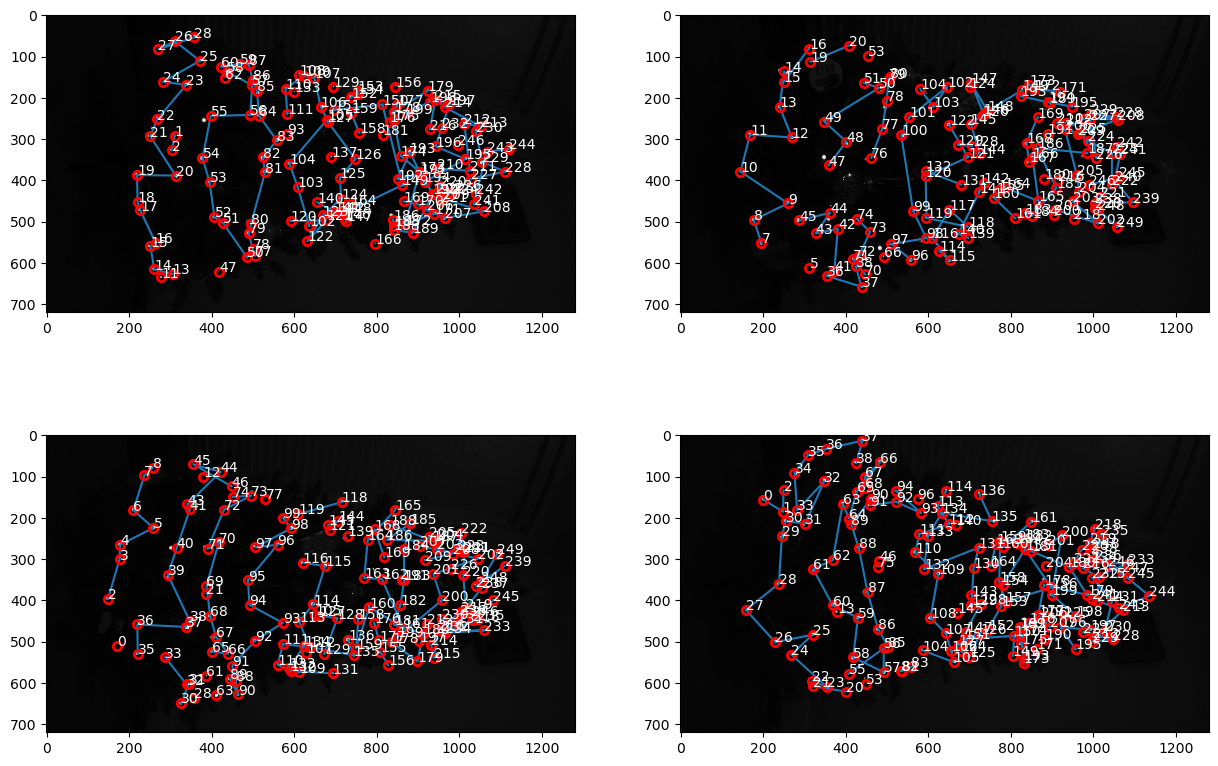

In [2]:
# check if detections is valid

nPov = len(bagFiles)

validPoints = np.all(np.isnan(allPoints), axis=0)[:,0]

plt.figure(figsize=(15,10))
for i in range(nPov):
    plt.subplot(2, 2, i+1), 
    plt.imshow(frames[i], cmap='gray')
    plt.plot(allPoints[i][:,0], allPoints[i][:,1], '-o', markerfacecolor="None",
         markeredgecolor='red', markeredgewidth=2)
    for j in range(numBulbs):
        if not np.isnan(allPoints[i][j,0]):
            plt.text(allPoints[i][j,0], allPoints[i][j,1], str(j), color=[1,1,1])
    # plt.xlim([0, cameraInfo.resolution[0]])
    # plt.ylim([cameraInfo.resolution[1], 0])

In [6]:
cameraMatrix = np.reshape(cameraInfo.K, [3, 3])
cameraDist = cameraInfo.D

# i, j = 0, 1
Rij, tij, retvalij = [], [], []
for i in range(nPov):
    Ri, ti, retvali = [], [], []
    for j in range(nPov):

        validPoints = ~(np.isnan(allPoints[i][:,0]) | np.isnan(allPoints[j][:,0]))
        retval, Eji, R, t, mask = cv2.recoverPose(allPoints[i][validPoints,:], allPoints[j][validPoints,:], 
            cameraMatrix, cameraDist, cameraMatrix, cameraDist, prob=0.9, method=cv2.LMEDS)
        
        Ri.append(R.T)
        ti.append(-R.T @ t)
        retvali.append(retval)

    Rij.append(Ri)
    tij.append(ti)
    retvalij.append(retvali)

retvalij

[[0, 57, 40, 85], [57, 0, 70, 47], [40, 70, 0, 83], [85, 47, 83, 0]]

In [4]:
R00, t00 = np.eye(3), np.zeros([3, 1])
R01, t01 = R00 @ Rij[0][1], R00 @ tij[0][1]
R02, t02 = R00 @ Rij[0][2], R00 @ tij[0][2]
R03, t03 = R00 @ Rij[0][3], R00 @ tij[0][3]

R0i = []
for i in range(nPov):
    r0i = []
    for j in range(nPov):
        r0i.append(Rij[0][j] @ Rij[i][j].T)
    R0i.append(r0i)

R0i[3]

[array([[ 0.81287644, -0.53713271, -0.22521178],
        [ 0.53752397,  0.54294837,  0.6451938 ],
        [-0.22427633, -0.64551957,  0.73007165]]),
 array([[ 0.77202402, -0.6195673 ,  0.14182832],
        [-0.51674871, -0.4819204 ,  0.70761819],
        [-0.37006713, -0.61958784, -0.69221473]]),
 array([[ 0.82660577,  0.46476444, -0.31735929],
        [ 0.55614982, -0.58828175,  0.5870451 ],
        [ 0.08614101, -0.66175418, -0.74475575]]),
 array([[-0.06301152, -0.2127322 ,  0.97507669],
        [-0.11101103, -0.96946131, -0.21868086],
        [ 0.99181959, -0.12202369,  0.03747161]])]

In [5]:
import math3d as m3d 

def triangulate_nviews(P, ip):
    """
    Triangulate a point visible in n camera views.
    P is a list of camera projection matrices.
    ip is a list of homogenised image points. eg [ [x, y, 1], [x, y, 1] ], OR,
    ip is a 2d array - shape nx3 - [ [x, y, 1], [x, y, 1] ]
    len of ip must be the same as len of P
    """
    if not len(ip) == len(P):
        raise ValueError('Number of points and number of cameras not equal.')
    n = len(P)
    M = np.ones([3*n, 4+n])
    for i, (x, p) in enumerate(zip(ip, P)):
        M[3*i:3*i+3, :4] = p
        M[3*i:3*i+2, 4+i] = -x
    V = np.linalg.svd(M)[-1]
    X = V[-1, :4]
    return X[:3] / X[3]


def triangulate_nviews2(P, ip):
    """
    Triangulate a point visible in n camera views.
    P is a list of camera projection matrices.
    ip is a list of homogenised image points. eg [ [x, y, 1], [x, y, 1] ], OR,
    ip is a 2d array - shape nx3 - [ [x, y, 1], [x, y, 1] ]
    len of ip must be the same as len of P
    """
    if not len(ip) == len(P):
        raise ValueError('Number of points and number of cameras not equal.')
    n = len(P)
    M = np.zeros([2*n, 4])
    for i, (x, p) in enumerate(zip(ip, P)):
        M[2*i : 2*i+2, :] = np.c_[
            x[1] * p[2] - p[1], 
            p[0] - x[0] * p[2]].T
    V = np.linalg.svd(M.T @ M)[-1]
    X = V[-1, :]
    return X[:3] / X[3]

npts = 6
objpoints = 2 * (np.random.rand(npts, 3) - 0.5)

# converts to cam frame
R0w, t0w = np.eye(3), np.c_[0.0, 0, 3].T
R1w, t1w = cv2.Rodrigues(np.r_[0, np.pi/2, 0])[0], np.c_[0, 0.5, 3].T
R2w, t2w = cv2.Rodrigues(np.r_[0, np.pi, 0])[0], np.c_[0, -0.5, 3].T

tfw0 = m3d.Transform(R0w, t0w[:,0]).inverse
tfw1 = m3d.Transform(R1w, t1w[:,0]).inverse
tf10 = tfw1.inverse * tfw0
R10, t10 = tf10.orient[:], tf10.pos[:][:,np.newaxis]

# R10 = R1w @ R0w.T
# t10 = t0w - t1w

imgpoints0 = cv2.projectPoints(objpoints, R0w, t0w, cameraMatrix, cameraDist)[0][:,0,:]
imgpoints1 = cv2.projectPoints(objpoints, R1w, t1w, cameraMatrix, cameraDist)[0][:,0,:]
imgpoints2 = cv2.projectPoints(objpoints, R2w, t2w, cameraMatrix, cameraDist)[0][:,0,:]

# add noise
imgpoints0n = imgpoints0 + np.random.randn(npts, 2) * 2
imgpoints1n = imgpoints1 + np.random.randn(npts, 2) * 2
imgpoints2n = imgpoints2 + np.random.randn(npts, 2) * 2

# add missing data
# imgpoints0n[0,0,:] = np.NaN
# imgpoints1n[-1,0,:] = np.NaN

retval, E10_est, R10_est, t10_est, mask = cv2.recoverPose(imgpoints0n, imgpoints1n, 
    cameraMatrix, cameraDist, cameraMatrix, cameraDist, method=cv2.LMEDS, prob=0.9, threshold=1)

# Ps = [cameraMatrix @ np.c_[R, t] for R, t in zip([R0w, R1w], [t0w, t1w])]
# objpoints_est = np.array([triangulate_nviews(Ps, [pts0, pts1]) 
#     for pts0, pts1 in zip(imgpoints0, imgpoints1)])

Ps = [cameraMatrix @ np.c_[R, t] for R, t in zip([R0w, R1w, R2w], [t0w, t1w, t2w])]
# Ps = [np.c_[R, t] for R, t in zip([R0w, R1w, R2w], [t0w, t1w, t2w])]
imgpoints0_norm = cv2.undistortPoints(imgpoints0n, cameraMatrix, cameraDist, P=cameraMatrix)[:,0,:]
imgpoints1_norm = cv2.undistortPoints(imgpoints1n, cameraMatrix, cameraDist, P=cameraMatrix)[:,0,:]
imgpoints2_norm = cv2.undistortPoints(imgpoints2n, cameraMatrix, cameraDist, P=cameraMatrix)[:,0,:]

objpoints_est = np.array([triangulate_nviews2(Ps, [pts0, pts1, pts2]) 
    for pts0, pts1, pts2 in zip(imgpoints0_norm, imgpoints1_norm, imgpoints2_norm)])

# retval, E, R, t, mask
# R10_est, R10
# t10_est, t10 / (t10.T @ t10)**0.5, retval
objpoints_est, objpoints

(array([[ 0.16338997,  0.92178832,  0.52311024],
        [ 0.85930245, -0.27490999, -0.24583654],
        [ 0.43310183,  0.62741171,  0.20787658],
        [ 0.39703086,  1.00027811, -0.7103436 ],
        [ 0.92123919,  0.32025262,  0.13345328],
        [ 0.14541641,  0.21071365,  0.57969587]]),
 array([[ 0.17390326,  0.92305077,  0.52928777],
        [ 0.86160394, -0.27328447, -0.24809084],
        [ 0.4263433 ,  0.63342532,  0.1744473 ],
        [ 0.39939214,  0.99572488, -0.70948798],
        [ 0.92717403,  0.31611789,  0.12449092],
        [ 0.15093377,  0.2188057 ,  0.55242337]]))

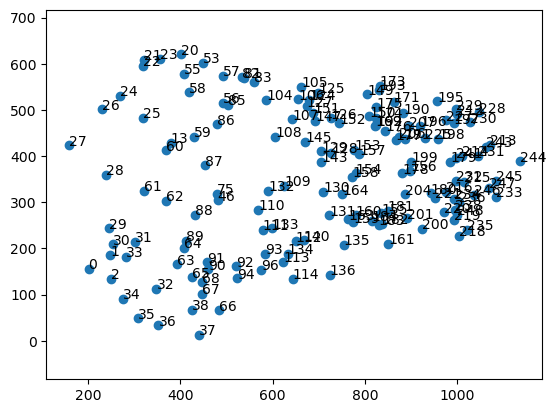

In [9]:
allPoints = np.array([(d[1], d[2]) for d in detections])
time = np.array([d[0] for d in detections])
numDetections = np.array([d[4] for d in detections])
bSize = np.array([d[3] for d in detections])

tStart = np.mean(time[(numDetections > 5) & (time < time[0] + 30)])
tEnd = np.mean(time[(numDetections > 5) & (time > time[-1] - 30)])

numBulbs = 50 * 5
ttime = np.linspace(tStart, tEnd, numBulbs + 2)[1:-1]
points = interp1d(time, allPoints.T)(ttime).T
period = (ttime[-1] - ttime[0]) / (numBulbs - 1)

# remove bad interpolation
for i, t in enumerate(ttime):
    if np.min(np.abs(time - t)) > 0.25*period:
        points[i,:] = [np.NaN, np.NaN]

# xrange = [900, 901]
xrange = [time[0], time[-1]]

plt.scatter(points[:,0], points[:,1]);
for i in range(numBulbs):
    if not np.isnan(points[i,0]):
        plt.text(points[i,0], points[i,1], str(i));
plt.axis('equal');

# plt.figure(figsize=(15, 10))
# plt.subplot(221), plt.plot(time, allPoints, 'o-', ttime, points, 's-'); 
# plt.grid(True); plt.xlim(xrange)
# plt.subplot(222), plt.plot(time, numDetections, 'o-'); plt.grid(True); plt.xlim(xrange)
# plt.subplot(223), plt.plot(time, bSize, 'o-'); plt.grid(True); plt.ylim([-10, 50]); plt.xlim(xrange)

In [7]:
%load_ext autoreload
%autoreload 2

from xmas_lights import Calibrator 

cameraMatrix = np.reshape(cameraInfo.K, [3, 3])
cameraDist = cameraInfo.D
cal = Calibrator(allPoints, cameraMatrix, cameraDist)

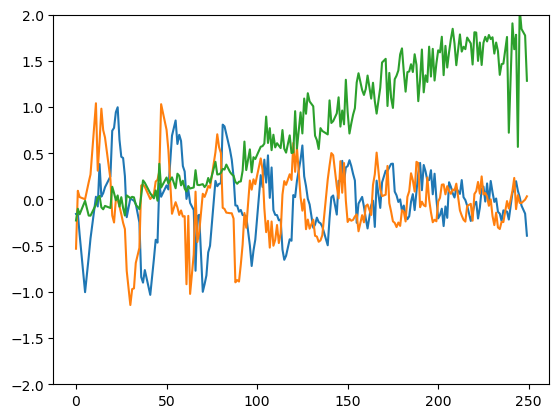

In [55]:
# plt.hist(numViews, np.arange(-0.5, 4.5));
# plt.plot(numViews);
# plt.plot(objpoints); plt.ylim([-2, 2]);



objpoints = np.array(objpoints)

invalidPoints = np.array(numViews) <= 1
objpoints[invalidPoints] = interp1d(np.argwhere(~invalidPoints)[:,0], 
    objpoints[~invalidPoints,:].T)(np.argwhere(invalidPoints)[:,0]).T
# objpoints[invalidPoints].shape

plt.plot(objpoints); plt.ylim([-2, 2]);


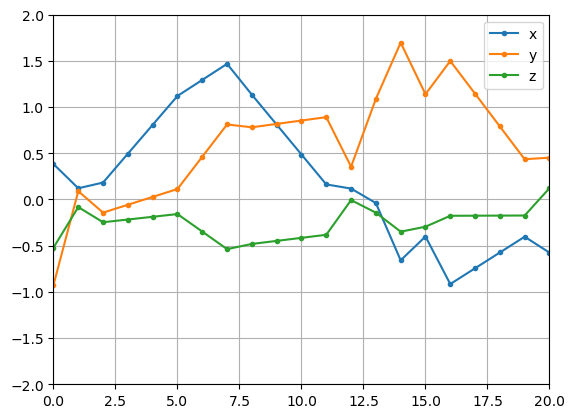

In [78]:
%reload_ext autoreload
from xmas_lights import Rod_from_Rxyz

rvecs = np.array([Rod_from_Rxyz(0, np.pi/2, 0), 
                  Rod_from_Rxyz(0, np.pi/2, np.pi/2), 
                  Rod_from_Rxyz(0, np.pi/2, np.pi), 
                  Rod_from_Rxyz(0, np.pi/2, np.pi*3/2)])
tvecs = np.array([[0, 0, 1.0], 
                  [0, 0, 1.0], 
                  [0, 0, 1.0], 
                  [0, 0, 1.0]], np.float32)

numViews = []
objpoints = []
allPoints_rect = np.array([cv2.undistortPoints(pts, cameraMatrix, cameraDist, P=cameraMatrix)[:,0,:] for pts in allPoints])
allP = np.array([cameraMatrix @ np.c_[cv2.Rodrigues(r)[0], t] for r, t in zip(rvecs, tvecs)])
for i in range(numBulbs):
    validViews = ~np.isnan(allPoints_rect[:,i,0])
    if np.sum(validViews) <= 1:
        # print("Point %d does not have enough views" % i)
        objpoints.append(np.ones([3]) * np.NaN)
    else:
        objpoints.append(triangulate_nviews2(allP[validViews], allPoints_rect[validViews,i,:]))
    numViews.append(np.sum(validViews))

objpoints = np.array(objpoints)
invalidPoints = np.array(numViews) <= 1
objpoints[invalidPoints] = interp1d(np.argwhere(~invalidPoints)[:,0], 
    objpoints[~invalidPoints,:].T)(np.argwhere(invalidPoints)[:,0]).T

plt.plot(objpoints, '.-'); plt.ylim([-2, 2]); plt.xlim([0, 20]); plt.grid(True), plt.legend(['x', 'y', 'z']);


# objpoints_est = np.array([triangulate_nviews2(Ps, [pts0, pts1, pts2]) 
#     for pts0, pts1, pts2 in zip(imgpoints0_norm, imgpoints1_norm, imgpoints2_norm)])

In [81]:
%reload_ext autoreload
from xmas_lights import Rod_from_Rxyz

rvecs = np.array([Rod_from_Rxyz(0, np.pi/2, 0), 
                  Rod_from_Rxyz(0, np.pi/2, -np.pi/2), 
                  Rod_from_Rxyz(0, np.pi/2, -np.pi), 
                  Rod_from_Rxyz(0, np.pi/2, -np.pi*3/2)])
tvecs = np.array([[0, 0, 1.0], 
                  [0, 0, 1.0], 
                  [0, 0, 1.0], 
                  [0, 0, 1.0]], np.float32)
# objpoints = (np.random.rand(numBulbs, 3) - [0.5, 0.5, 0.5]) * 0.5
# objpoints[:,2] = objpoints[:,2] + np.linspace(-0.5, 0.5, numBulbs)

numViews = []
objpoints = []
allPoints_rect = np.array([cv2.undistortPoints(pts, cameraMatrix, cameraDist, P=cameraMatrix)[:,0,:] for pts in allPoints])
allP = np.array([cameraMatrix @ np.c_[cv2.Rodrigues(r)[0], t] for r, t in zip(rvecs, tvecs)])
for i in range(numBulbs):
    validViews = ~np.isnan(allPoints_rect[:,i,0])
    objpoints.append(triangulate_nviews2(allP[validViews], allPoints_rect[validViews,i,:]))
    # if np.sum(validViews) <= 1:
    #     print("Point %d does not have enough views" % i)
    numViews.append(np.sum(validViews))

objpoints = np.array(objpoints)
invalidPoints = np.array(numViews) <= 1
objpoints[invalidPoints] = interp1d(np.argwhere(~invalidPoints)[:,0], 
    objpoints[~invalidPoints,:].T)(np.argwhere(invalidPoints)[:,0]).T

x0 = Calibrator.pack(rvecs, tvecs, objpoints)
lb = x0 - np.r_[[np.pi*2]*4*3, [1]*4*3, [2]*numBulbs*3]
ub = x0 + np.r_[[np.pi*2]*4*3, [1]*4*3, [2]*numBulbs*3]

lb[:3] = ub[:3] = x0[:3]
lb[12:15] = ub[12:15] = x0[12:15]
# lb[12:15] = ub[12:15] = x0[12:15]
# lb[12] = lb[15] = lb[18] = lb[21] = ub[12] = ub[15] = ub[18] = ub[21] = 0

# rvecs, tvecs, objpoints, res = cal.extrinsic_calibration(x0=x0, ub=ub, lb=lb, useJac=True)

1.80e+27


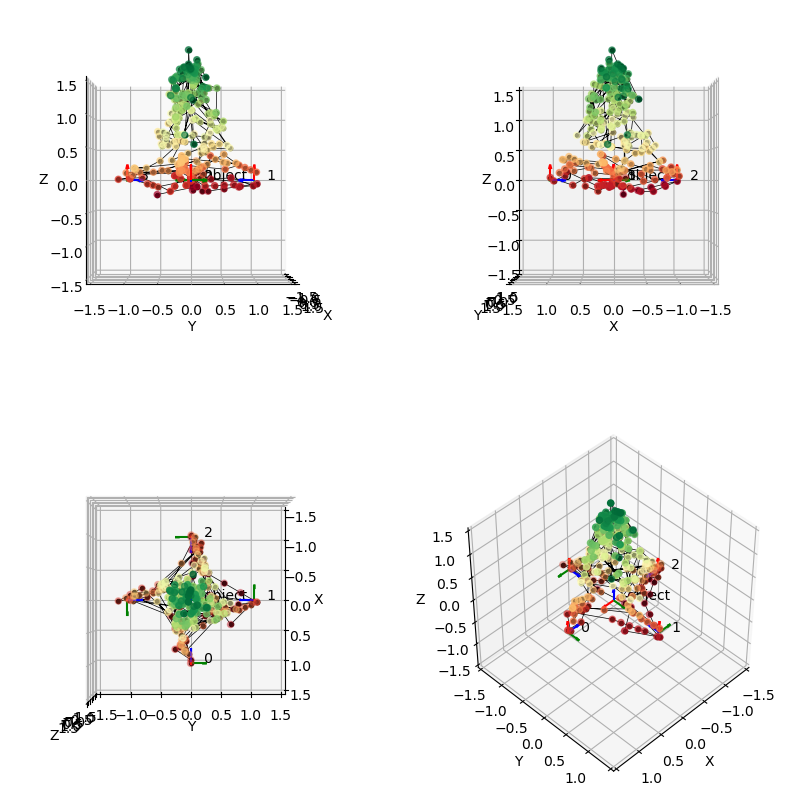

In [82]:
from mpl_toolkits.mplot3d import Axes3D
from xmas_lights import plot_extrinsics

# corners = objpoints[0,:,:]

# fig = plt.figure(figsize=(10,10))
# ax = fig.gca(projection='3d')
# ax.plot(corners[:,0], corners[:,1], corners[:,2], 'k.-', lw=0.5);

# ax.view_init(30, 45)

# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_zlabel('Z')

# rvecs = np.array([Rod_from_Rxyz(0, np.pi/2, 0), 
#                   Rod_from_Rxyz(0, np.pi/2, np.pi/2), 
#                   Rod_from_Rxyz(0, np.pi/2, np.pi), 
#                   Rod_from_Rxyz(0, np.pi/2, np.pi*3/2)])
# tvecs = np.array([[0, 0, 1.5], 
#                   [0, 0, 1.5], 
#                   [0, 0, 1.5], 
#                   [0, 0, 1.5]], np.float32)
# objpoints = (np.random.rand(numBulbs, 3) - [0.5, 0.5, 0.5]) * 0.2
# objpoints[:,2] = objpoints[:,2] + np.linspace(-0.5, 0.5, numBulbs)

# x0 = Calibrator.pack(rvecs, tvecs, objpoints)

plot_extrinsics(rvecs, tvecs, objpoints);
print("%.2e" % cal.cost_fcn(x0))

In [24]:
imgpts[0].shape, allPoints[0].shape

((250, 1, 2), (250, 2))

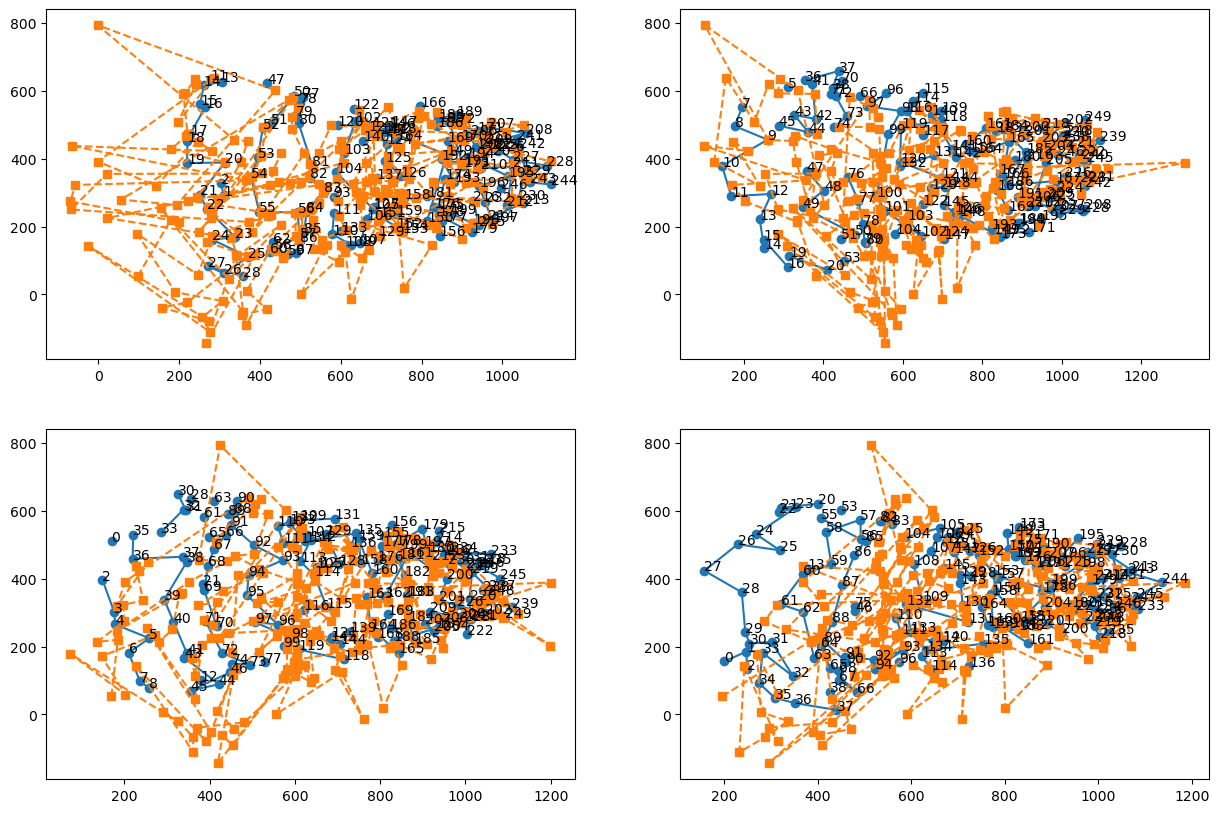

In [35]:
imgpts = cal.project_points(rvecs, tvecs, objpoints)[0]

plt.figure(figsize=(15,10))
for i in range(nPov):
    # np.concatenate([imgpts[i][:,0,:], allPoints[i], allPoints[i]*np.NaN], axis=2)
    
    plt.subplot(2,2,i+1)
    plt.plot(allPoints[i][:,0], allPoints[i][:,1], 'o-', imgpts[i][:,0,0], imgpts[0][:,0,1], 's--')
    # plt.quiver(allPoints[i][:,0], allPoints[i][:,1], 
    #     imgpts[i][:,0,0]-allPoints[i][:,0], imgpts[i][:,0,1]-allPoints[i][:,1])
    for j in range(numBulbs):
        # if not np.isnan(imgpts[i][j,0,0]):
            # plt.text(imgpts[i][j,0,0], imgpts[i][j,0,1], str(j))
        if not np.isnan(allPoints[i][j,0]):
            plt.text(allPoints[i][j,0], allPoints[i][j,1], str(j))

In [194]:
from scipy.optimize import check_grad


cameraMatrix = np.reshape(cameraInfo.K, [3, 3])
cameraDist = cameraInfo.D
cal = Calibrator(allPoints, cameraMatrix, cameraDist)

err = check_grad(cal.cost_fcn, cal.jac_fcn, x0)
print(err)

17.89739572923188


In [193]:
cameraInfo.D

(-0.420543, 0.167051, 0.000454, -0.000487, 0.0)